# DSKUS Group 1 EDA
Date: Apr 13/2023

Professor Mentor: Dr. Hyungwook Kim

Industry Mentor: Dr. Rujie Yin

Group Members:
- Kyi Moe Tun
- Palak Maniar
- Youmin Ko
- Hyunji Kim

### Datasets Description


| Dataset Name                        | Source                                      | Time Period             | Size       | Description                                                                                                                                                                                                                              |
|-------------------------------------|---------------------------------------------|-------------------------|------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| GCP Fossil CO₂ Emissions Dataset    | [Global Carbon Project (GCP)](https://zenodo.org/record/5569235)                 | 1751 - 2021             | (63104, 11)| Comprehensive global and national CO₂ emissions data since 2001; includes data on CO₂ emissions from various sources, such as coal, oil, gas, cement, flaring, and other sources.                                                        |
| Climate Watch Dataset               | [International Energy Agency (IEA), U.S. Environmental Protection Agency, U.N. Food and Agriculture Organization, Global Carbon Project](https://www.climatewatchdata.org)   | 1990 - 2019             | (10, 30)    | Covers all sectors and gases, including energy sub-sectors and Kyoto GHGs (CH4, CO2, N2O, F-gases); does not use countries' official inventories reported to the UNFCCC.                                                                |
| CO₂ Emission Dataset from Kaggle    | International Energy Agency (IEA) and United Nations Framework Convention on Climate Change (UNFCCC) | 1960 - 2020             | Varies by datasets    | Provides a comprehensive overview of the amount of CO₂ emitted by each country; includes information on CO₂ emissions by country from 1960 to 2020; covers all countries in the world and is compiled from various sources.              |
| Global Energy Consumption & Renewable Energy Generation | [Kaggle Renewable Power Generation](https://www.kaggle.com/datasets/jamesvandenberg/renewable-power-generation) | 1990-2020 (Energy Consumption), 1997-2017 (Renewable Energy Generation) | Varies by datasets | Shows energy consumption by continent and country in Terawatt-Hour (TWh); includes non-renewable energy production and total amount of energy produced through renewable and non-renewable sources; data on top 20 countries provided. |
| CO2 Emission Dataset                | [Climate Change Org](https://climatedata.imf.org/pages/climatechange-data) | 1990 - 2019 | (215, 35) | Covers the CO2 emissions from various countries; subdivides data into various regions like the South Asian and North American regions which have been highlighted in visualization. |
| Climate Policies Dataset                | [Climate Policies Database](https://climatepolicydatabase.org) | 1990 - 2022 | (461, 28) | The Climate Policy Database is a comprehensive, periodically updated resource for national climate mitigation policies, developed by NewClimate Institute in collaboration with PBL Netherlands Environmental Assessment Agency and Wageningen University and Research. |


![Understanding the dataset](../Figures/climate_sources.png)

In [38]:
# Installing packages
# Use pip to for installation
#pandas
#matplotlib
#seaborn
#numpy
#plotly
#scipy
#wordcloud
#gensim
#bertopic
#matplotlib_venn



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib_venn: filename=matplotlib_venn-0.11.9-py3-none-any.whl size=33000 sha256=c985a2e06c785fc9f4ea36608b46964f82fd431f9ac31dc558734fe71adb2823
  Stored in directory: /Users/kyimoetun/Library/Caches/pip/wheels/bd/e2/a0/b922199922d1c6d4c3a9827bdb66b6d8924bb7cfdc5378deb1
Successfully built matplotlib_venn

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [39]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import warnings
from scipy import interpolate, stats
from matplotlib_venn import venn2

warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
# reading the dataframes
emission = pd.read_csv('../Datasets/emission_by_country.csv')  # GCP Fossil CO₂ Emissions Dataset
ghg = pd.read_csv('../Datasets/ghg-emissions.csv', skipfooter=2)  # Climate Watch Dataset
cont_consump = pd.read_csv("../Datasets/Continent_Consumption_TWH.csv") # Global Energy Consumption Dataset
country_consump = pd.read_csv("../Datasets/Country_Consumption_TWH.csv") # Global Energy Consumption Dataset
nonre_eng = pd.read_csv("../Datasets/nonRenewablesTotalPowerGeneration.csv") # Global Energy Consumption Dataset
re_eng_gen_90_17 = pd.read_csv("../Datasets/renewablePowerGeneration97-17.csv") # Global Energy Consumption Dataset
re_eng_tot_gen = pd.read_csv("../Datasets/renewablesTotalPowerGeneration.csv") # Global Energy Consumption Dataset
re_eng_countries = pd.read_csv("../Datasets/top20CountriesPowerGeneration.csv") # Global Energy Consumption Dataset
ren_gen = pd.read_csv("../Datasets/USA_Ren_Gen.csv")  
co2_df = pd.read_csv('../Datasets/World_CO2_emission.csv')
us_policies = pd.read_csv('../Datasets/climate_policy_database_policies_US.csv')
kor_policies = pd.read_csv('../Datasets/climate_policy_database_policies_KOR.csv')

#### Data Cleaning

We will do the data cleaning first, individually on each dataset in the order as above while importing them.

&emsp; I chose to filter emission data after the year 2000 because the first satellite measurements, starting with the IMG on ADEOS I in 1996, were less reliable, and high-precision CO2 observing satellites like AIRS and GOSAT only commenced operations in the 2000s, offering more accurate and consistent data for analysis. [Source](https://en.wikipedia.org/wiki/Space-based_measurements_of_carbon_dioxide)

In [4]:
# emission dataset
# filtering out the rows after 2000
ems = emission[emission['Year'] > 2000].reset_index(drop=True)

# removing rows with null values in the ISO 3166-1 alpha-3 column
rows_to_remove = ems[ems['ISO 3166-1 alpha-3'].isna()]['Country'].unique().tolist()
ems = ems[~ems['Country'].isin(rows_to_remove)]

# Define the list of columns to check for null values
columns_to_check = ['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']
# Remove rows where the specified columns have null values
ems.dropna(subset=columns_to_check, how='all', inplace=True)

In [5]:
ems[ems.Country=='Global'].head()

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
4851,Global,WLD,2001,25668.048326,9255.256797,10390.668975,4773.584851,754.331663,281.128017,213.078023,4.119578
4852,Global,WLD,2002,26281.037468,9678.959137,10385.864180,4905.853640,796.052479,298.553835,215.754196,4.163394
4853,Global,WLD,2003,27651.596453,10518.463642,10679.654448,5081.468111,852.252693,299.375515,220.382043,4.324685
4854,Global,WLD,2004,28636.695037,10871.584335,11042.504634,5257.190057,910.566319,323.802545,231.047147,4.422142
4855,Global,WLD,2005,29614.602256,11543.334878,11139.399176,5380.665522,964.306101,345.094230,241.802350,4.515677


In [6]:
# leaving out the global row as it is the total of all the countries
ems = ems[~ems['Country'].isin(['Global'])]
# we could see the total emission in the global row as above
ems.groupby('Year')[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']].sum().reset_index().head()

,Year,Coal,Oil,Gas,Cement,Flaring,Other
0,2001,9255.256798,10390.668974,4773.584850,754.331664,281.128018,213.078025
1,2002,9678.959137,10385.864176,4905.853641,796.052479,298.553838,215.754198
2,2003,10518.463643,10679.654450,5081.468111,852.252690,299.375519,220.382040
3,2004,10871.584333,11042.504634,5257.190056,910.566322,323.802542,231.047146
4,2005,11543.334876,11139.399176,5380.665520,964.306102,345.094230,241.802353


In [7]:
# cont_consump, country_consump, nonre_eng, re_eng_gen_90_17, re_eng_tot_gen, re_eng_countries datasets
# Change the data type of 'Year' to int and drop the NaN value
country_consump = country_consump.dropna()
country_consump['Year'] = country_consump['Year'].astype(int)
cont_consump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           31 non-null     int64  
 1   World          31 non-null     float64
 2   OECD           31 non-null     float64
 3   BRICS          31 non-null     float64
 4   Europe         31 non-null     float64
 5   North America  31 non-null     float64
 6   Latin America  31 non-null     float64
 7   Asia           31 non-null     float64
 8   Pacific        31 non-null     float64
 9   Africa         31 non-null     float64
 10  Middle-East    31 non-null     float64
 11  CIS            31 non-null     float64
dtypes: float64(11), int64(1)
memory usage: 3.0 KB


In [58]:
# Find indices of NaN values and drop them in the country_consump dataset
country_consump.isna().to_numpy().nonzero()
country_consump.dropna(inplace=True)
# Rename columns in the country_consump dataset to replace spaces with periods
country_consump.rename(columns={"Saudi Arabia": "Saudi.Arabia",
                                "United Kingdom": "United.Kingdom",
                                "United States": "United.States",
                                "New Zealand": "New.Zealand",
                                "South Africa": "South.Africa",
                                "South Korea": "South.Korea",
                                "United Arab Emirates": "United.Arab.Emirates"}, inplace=True)
country_consump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  31 non-null     int64  
 1   China                 31 non-null     float64
 2   United.States         31 non-null     float64
 3   Brazil                31 non-null     float64
 4   Belgium               31 non-null     float64
 5   Czechia               31 non-null     float64
 6   France                31 non-null     float64
 7   Germany               31 non-null     float64
 8   Italy                 31 non-null     float64
 9   Netherlands           31 non-null     float64
 10  Poland                31 non-null     float64
 11  Portugal              31 non-null     float64
 12  Romania               31 non-null     float64
 13  Spain                 31 non-null     float64
 14  Sweden                31 non-null     float64
 15  United.Kingdom        31 

In [59]:
# Drop rows with NaN values in the nonre_eng dataset
nonre_eng.dropna(inplace=True)

# Rename columns in the nonre_eng dataset for clarity and brevity
nonre_eng.rename(columns={"Coal (incl. Peat)": "Coal",
                          "Petroleum and Other Liquids": "Petroleum",
                          "Nuclear": "Nuclear Energy",
                          "Natural Gas": "Natural Gas (Excluding Supplemental Gaseous Fuels)",
                          "Other": "Other Nonrenewable Energy"}, inplace=True)
nonre_eng.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Mode of Generation  8 non-null      object 
 1   Contribution (TWh)  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


In [60]:
# ren_gen, co2_df datasets
# Drop the unnecessary 'Unnamed: 0' column from the ren_gen dataset
ren_gen.drop(columns="Unnamed: 0", inplace=True)

# Create a new 'Date' column from the 'YEAR' and 'MONTH' columns, then set it as the index
ren_gen["Date"] = pd.to_datetime(dict(year=ren_gen["YEAR"], month=ren_gen["MONTH"], day=1))
ren_gen = ren_gen.set_index("Date")

# Drop the now redundant 'YEAR' and 'MONTH' columns from the ren_gen dataset
ren_gen.drop(columns=["YEAR", "MONTH"], inplace=True)


In [61]:
# Filter the ren_gen dataset to get the total generation data for the US
total_gen = ren_gen[ren_gen["STATE"] == "US-TOTAL"]

# Filter out rows with 'Total Electric Power Industry' and 'Total' energy sources
total_gen = total_gen[(total_gen["TYPE OF PRODUCER"] != "Total Electric Power Industry") &
                      (total_gen["ENERGY SOURCE"] != "Total")]

# Group and sum the data by 'Date' and 'TYPE OF PRODUCER', then convert the generation to TWh
plot1 = total_gen.groupby(by=["Date", "TYPE OF PRODUCER"]).sum().reset_index()
plot1["Generation (TWh)"] = plot1["GENERATION (Megawatthours)"] / 1000000

# Group and sum the data by 'Date' and 'ENERGY SOURCE', then convert the generation to TWh
plot2 = total_gen.groupby(by=["Date", "ENERGY SOURCE"]).sum().reset_index()
plot2["Generation (TWh)"] = plot2["GENERATION (Megawatthours)"] / 1000000

# Calculate the total generation by energy source and sort the results in descending order
significant = plot2.groupby(by="ENERGY SOURCE").sum()["Generation (TWh)"].reset_index()
total_generation = significant.sort_values("Generation (TWh)", ascending=False)


### Exploratory Data Analysis
 &emsp; In this section, we will explore the datasets using different kinds of plots such as bar charts, line charts, etc. In addition to that, we will provide a brief explanation of each plot right below.

#### Comparison of contribution to CO2 emission by different fuel types over the years (2001-2021)

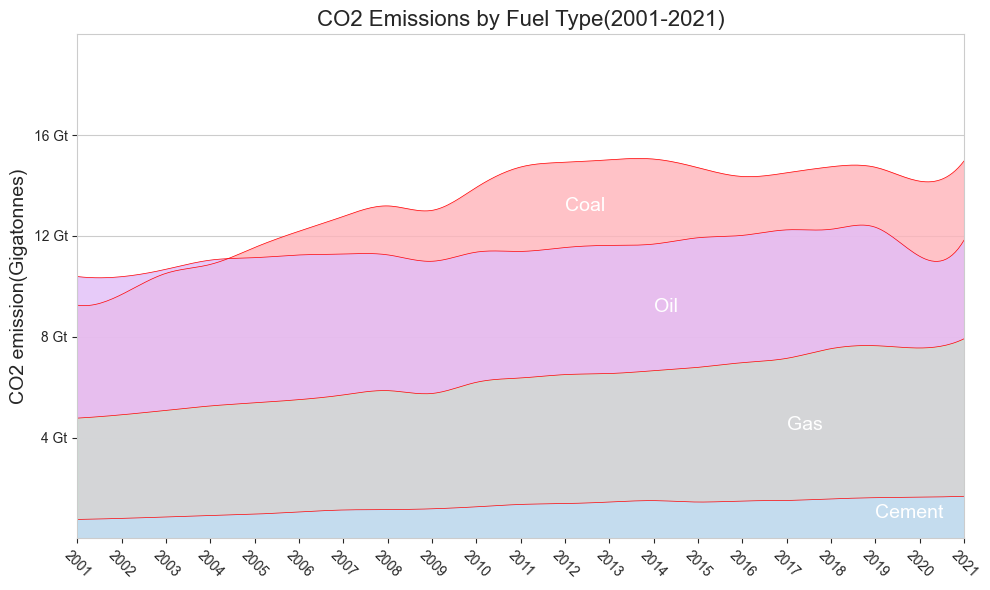

In [8]:
# Prepare the data
emissions_by_fuel_type = ems.groupby('Year')[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']].sum().reset_index()

# Set up the plot
sns.set_style('whitegrid', {'axes.grid': False, 'axes.grid.axis': 'y', 'xtick.bottom': True, 'ytick.left': True})
fig, ax = plt.subplots(figsize=(10, 6))

# Define a function to plot smooth area curves with black boundary lines
def plot_smooth_area_curve(years, values, color, label, alpha):
    x_smooth = np.linspace(years.min(), years.max(), 300)
    y_smooth = interpolate.interp1d(years, values, kind='cubic')(x_smooth)
    ax.fill_between(x_smooth, y_smooth, color=color, label=label, alpha=alpha)
    ax.plot(x_smooth, y_smooth, color='red', linewidth=0.5)

# Plot the data
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Coal'], '#FFB3BA', 'Coal', 0.8)
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Oil'], '#E2BEF8', 'Oil', 0.8)
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Gas'], '#C8E6C9', 'Gas', 0.6)
plot_smooth_area_curve(emissions_by_fuel_type['Year'], emissions_by_fuel_type['Cement'], '#BAE1FF', 'Cement', 0.6)

# Customize the plot
ax.set_xticks(emissions_by_fuel_type['Year'])
ax.set_xticklabels(emissions_by_fuel_type['Year'], rotation=-45)

# Set the x-axis limits to the minimum and maximum years
ax.set_xlim(emissions_by_fuel_type['Year'].min(), emissions_by_fuel_type['Year'].max())

ax.set_yticks([4e3, 8e3, 12e3, 16e3])
ax.set_yticklabels(['4 Gt', '8 Gt', '12 Gt', '16 Gt'])
ax.set_ylim(0, 20e3)
ax.set_ylabel('CO2 emission(Gigatonnes)', fontsize=14)

# Add text annotations
ax.text(2012, 13e3, 'Coal', color='white', size=14)
ax.text(2014, 9e3, 'Oil', color='white', size=14)
ax.text(2017, 4.3e3, 'Gas', color='white', size=14)
ax.text(2019, 0.8e3, 'Cement', color='white', size=14)

# Set the horizontal grid
plt.grid(axis='y')
plt.title('CO2 Emissions by Fuel Type(2001-2021)', fontsize=16)
plt.tight_layout()
plt.show()


&emsp; The plot provides a visual representation of **carbon dioxide emissions (in gigatonnes)** from various fuel sources over a **20-year period from 2001 to 2021**. The data reveals a general **upward trend** in emissions across most fuel sources, with **coal** being the **highest emitter**, followed by **oil** and **gas**. 

&emsp; Interestingly, there was a **downward trend in the year 2019** significantly impacted by the **coronavirus pandemic**, during which many countries imposed lockdowns to contain the virus, resulting in restricted industrial activities. 

&emsp; Although most sources show an upward trend in CO2 emissions over the years, the **cement industry** shows a relatively **stable trend** compared to the others.


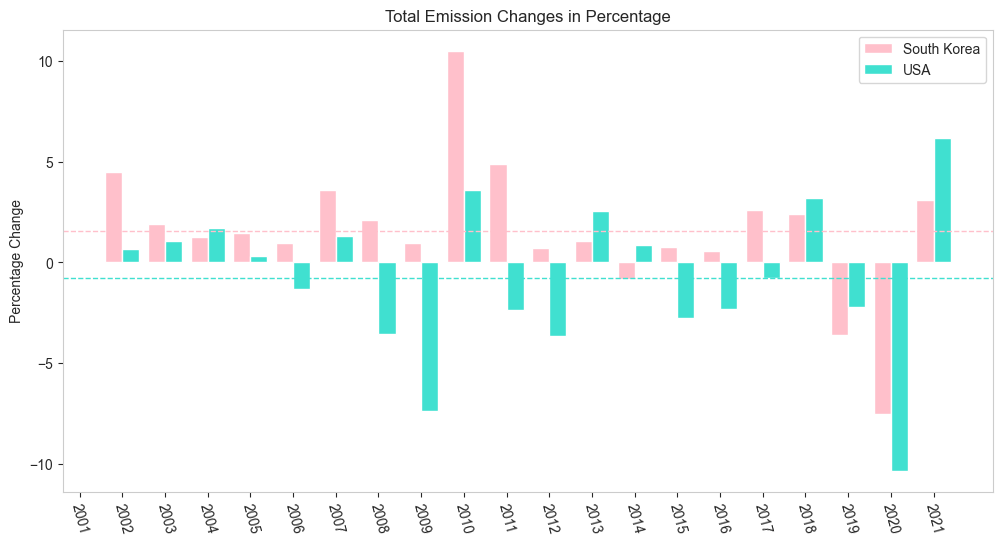

In [9]:
# Filter rows where the country is either USA or South Korea
ems_filtered = ems[(ems['Country'] == 'South Korea') | (ems['Country'] == 'USA')]

# Calculate the percentage change in total emissions
ems_filtered['Percentage Change'] = ems_filtered.groupby('Country')['Total'].pct_change() * 100

# Filter data for South Korea and the USA
south_korea = ems_filtered[ems_filtered['Country'] == 'South Korea']
usa = ems_filtered[ems_filtered['Country'] == 'USA']

# Calculate the average change in emissions for both countries
south_korea_change = south_korea['Total'].pct_change().mean()*100
usa_change = usa['Total'].pct_change().mean()*100

# Create a side-by-side bar plot
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4

ax.bar(south_korea['Year'], south_korea['Percentage Change'], width, label='South Korea', color='Pink')
ax.bar(usa['Year'] + width, usa['Percentage Change'], width, label='USA', color='Turquoise')

# Overlaying the average change lines
ax.axhline(south_korea_change, color='Pink', linestyle='dashed', linewidth=1)
ax.axhline(usa_change, color='Turquoise', linestyle='dashed', linewidth=1)

ax.set_ylabel('Percentage Change')
ax.set_title('Total Emission Changes in Percentage')
ax.set_xticks(usa['Year'] + width / 2)
ax.set_xticklabels(usa['Year'])
ax.set_xticklabels(usa['Year'], rotation=-75)

ax.legend()

plt.show()


#### Hypothesis 1
&emsp; Is there a difference in the rate of change in CO2 emissions between US and South Korea?

In [10]:
# Test for normality using Shapiro-Wilk test
sk_stat, sk_p_value = stats.shapiro(south_korea['Percentage Change'].dropna())
usa_stat, usa_p_value = stats.shapiro(usa['Percentage Change'].dropna())
print(f'South Korea: W-statistic: {sk_stat}, p-value: {sk_p_value}')
print(f'USA: W-statistic: {usa_stat}, p-value: {usa_p_value}')

# If the p-values of both countries are greater than the significance level (e.g., 0.05), we can proceed with the t-test
if sk_p_value > 0.05 and usa_p_value > 0.05:
    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(np.nan_to_num(south_korea['Percentage Change']), np.nan_to_num(usa['Percentage Change']), equal_var=False)
    print(f'T-statistic: {t_stat}, p-value: {p_value}')
else:
    print('At least one of the distributions is not normal. Consider using a non-parametric test, such as the Mann-Whitney U test.')


South Korea: W-statistic: 0.8857294321060181, p-value: 0.02246379666030407
USA: W-statistic: 0.9583922624588013, p-value: 0.512252151966095
At least one of the distributions is not normal. Consider using a non-parametric test, such as the Mann-Whitney U test.


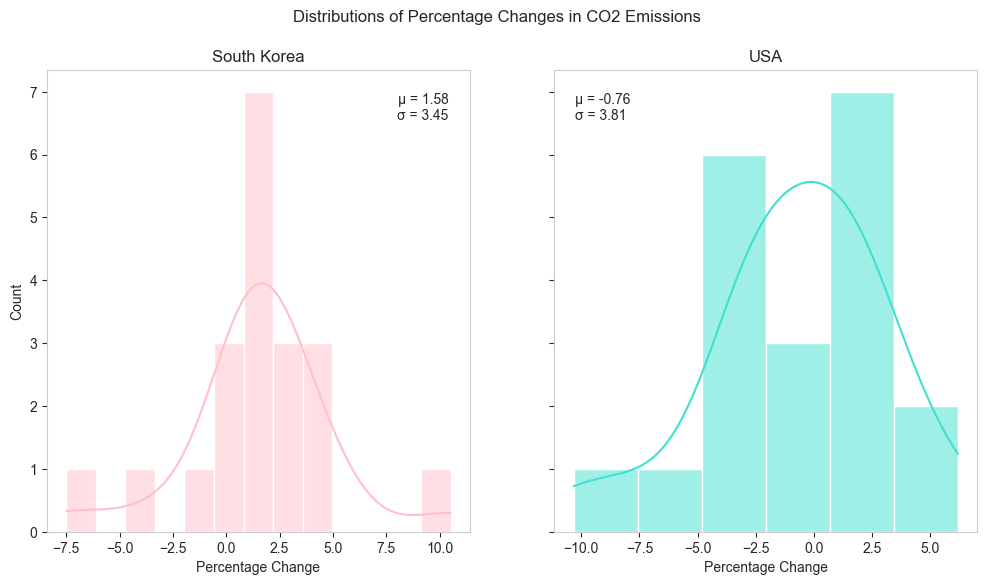

In [11]:
# Create side-by-side distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# South Korea plot
sns.histplot(data=south_korea, x='Percentage Change', kde=True, ax=ax1, color='Pink')
ax1.set_title('South Korea')
ax1.set_xlabel('Percentage Change')
ax1.text(0.95, 0.95, f"μ = {south_korea['Percentage Change'].mean():.2f}\nσ = {south_korea['Percentage Change'].std():.2f}",
         transform=ax1.transAxes, ha='right', va='top')

# USA plot
sns.histplot(data=usa, x='Percentage Change', kde=True, ax=ax2, color='Turquoise')
ax2.set_title('USA')
ax2.set_xlabel('Percentage Change')
ax2.text(0.05, 0.95, f"μ = {usa['Percentage Change'].mean():.2f}\nσ = {usa['Percentage Change'].std():.2f}",
         transform=ax2.transAxes, ha='left', va='top')

# Add a common title for both plots
fig.suptitle('Distributions of Percentage Changes in CO2 Emissions')

plt.show()


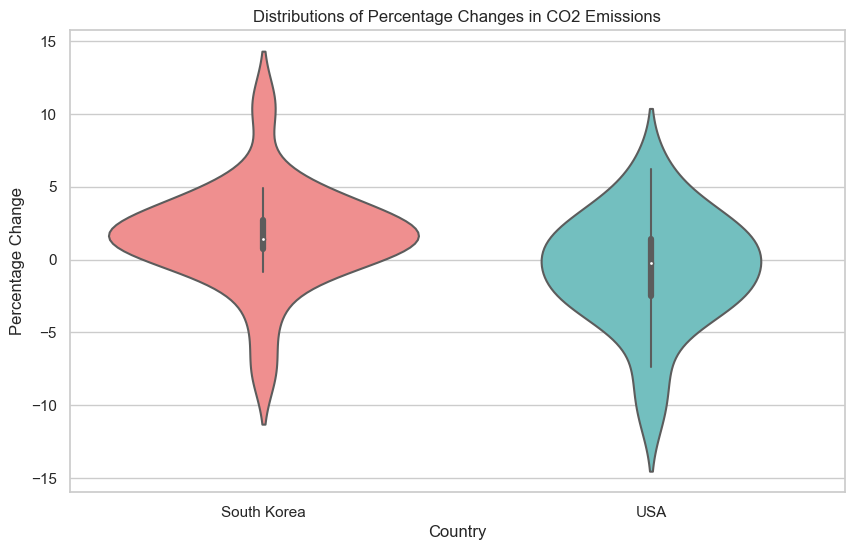

In [134]:
# Combine the data into a single dataframe
south_korea['Country'] = 'South Korea'
usa['Country'] = 'USA'
combined_data = pd.concat([south_korea, usa], ignore_index=True)

# Create violin plots
fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.violinplot(data=combined_data, x='Country', y='Percentage Change', inner='box', 
               palette=['Pink', 'Turquoise'], ax=ax)

# Set plot title and labels
ax.set_title('Distributions of Percentage Changes in CO2 Emissions')
ax.set_xlabel('Country')
ax.set_ylabel('Percentage Change')

plt.show()

In [12]:
from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
result = mannwhitneyu(south_korea['Percentage Change'].dropna(), usa['Percentage Change'].dropna())

print("Mann-Whitney U test:")
print(f"U-statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")


Mann-Whitney U test:
U-statistic: 275.0
P-value: 0.043880384461220855


- **Mann-Whitney U test** for comparing percentage change in CO₂ emissions (2001-2021) between South Korea and the United States:
    - **U-statistic:** 275.0
    - **P-value:** 0.04388

- P-value < 0.05 indicates a **significant difference** in CO₂ emissions trends between the countries. In this case, the test provides evidence that the distributions of the percentage changes in CO2 emissions are significantly different between the two countries.

- Possible factors driving differences:
    1. Energy policies
    2. Industrial growth
    3. Renewable energy adoption

- Further investigation needed to identify specific contributing factors and understand implications for climate change mitigation in each country.


&emsp; Let's dig deeper into the energy policies implemented in US over the past few years.

In [15]:
from collections import defaultdict

def get_word_count(dataset, column_name, stopwords=None):
    if stopwords is None:
        stopwords = {'and'}

    word_count = defaultdict(int)
    sectors = dataset[column_name].unique()

    for sector in sectors:
        words = sector.split(', ')
        clean_words = []
        for word in words:
            clean_word = ' '.join(w for w in word.split() if w.lower() not in stopwords)
            clean_words.append(clean_word)
        for clean_word in clean_words:
            word_count[clean_word] += 1

    return word_count


In [16]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

def generate_word_cloud(data, image_path, title, column_name=None, word_count=None):
    mask = np.array(Image.open(image_path))

    if word_count is None:
        text = " ".join(entry for entry in data[column_name].dropna())
        wordcloud = WordCloud(
            background_color='black',
            width=800,
            height=800,
            max_words=10,
            colormap='viridis',
            max_font_size=70,
            mask=mask,
            random_state=42,
            contour_width=0,
            contour_color='black',
            scale=3  # Increase the scale for tighter fitting
        ).generate(text)
    else:
        filtered_word_count = {k: v for k, v in word_count.items() if v > threshold}
        wordcloud = WordCloud(
            background_color='black',
            width=800,
            height=800,
            max_words=30,
            colormap='viridis',
            max_font_size=70,
            mask=mask,
            random_state=42,
            contour_width=0,
            contour_color='black',
            scale=3  # Increase the scale for tighter fitting
        ).generate_from_frequencies(filtered_word_count)

    plt.figure(figsize=(8, 8), dpi=300)
    plt.imshow(wordcloud, interpolation='Bilinear')
    plt.axis("off")
    plt.title(title, fontsize=10, fontweight='bold')
    plt.show()


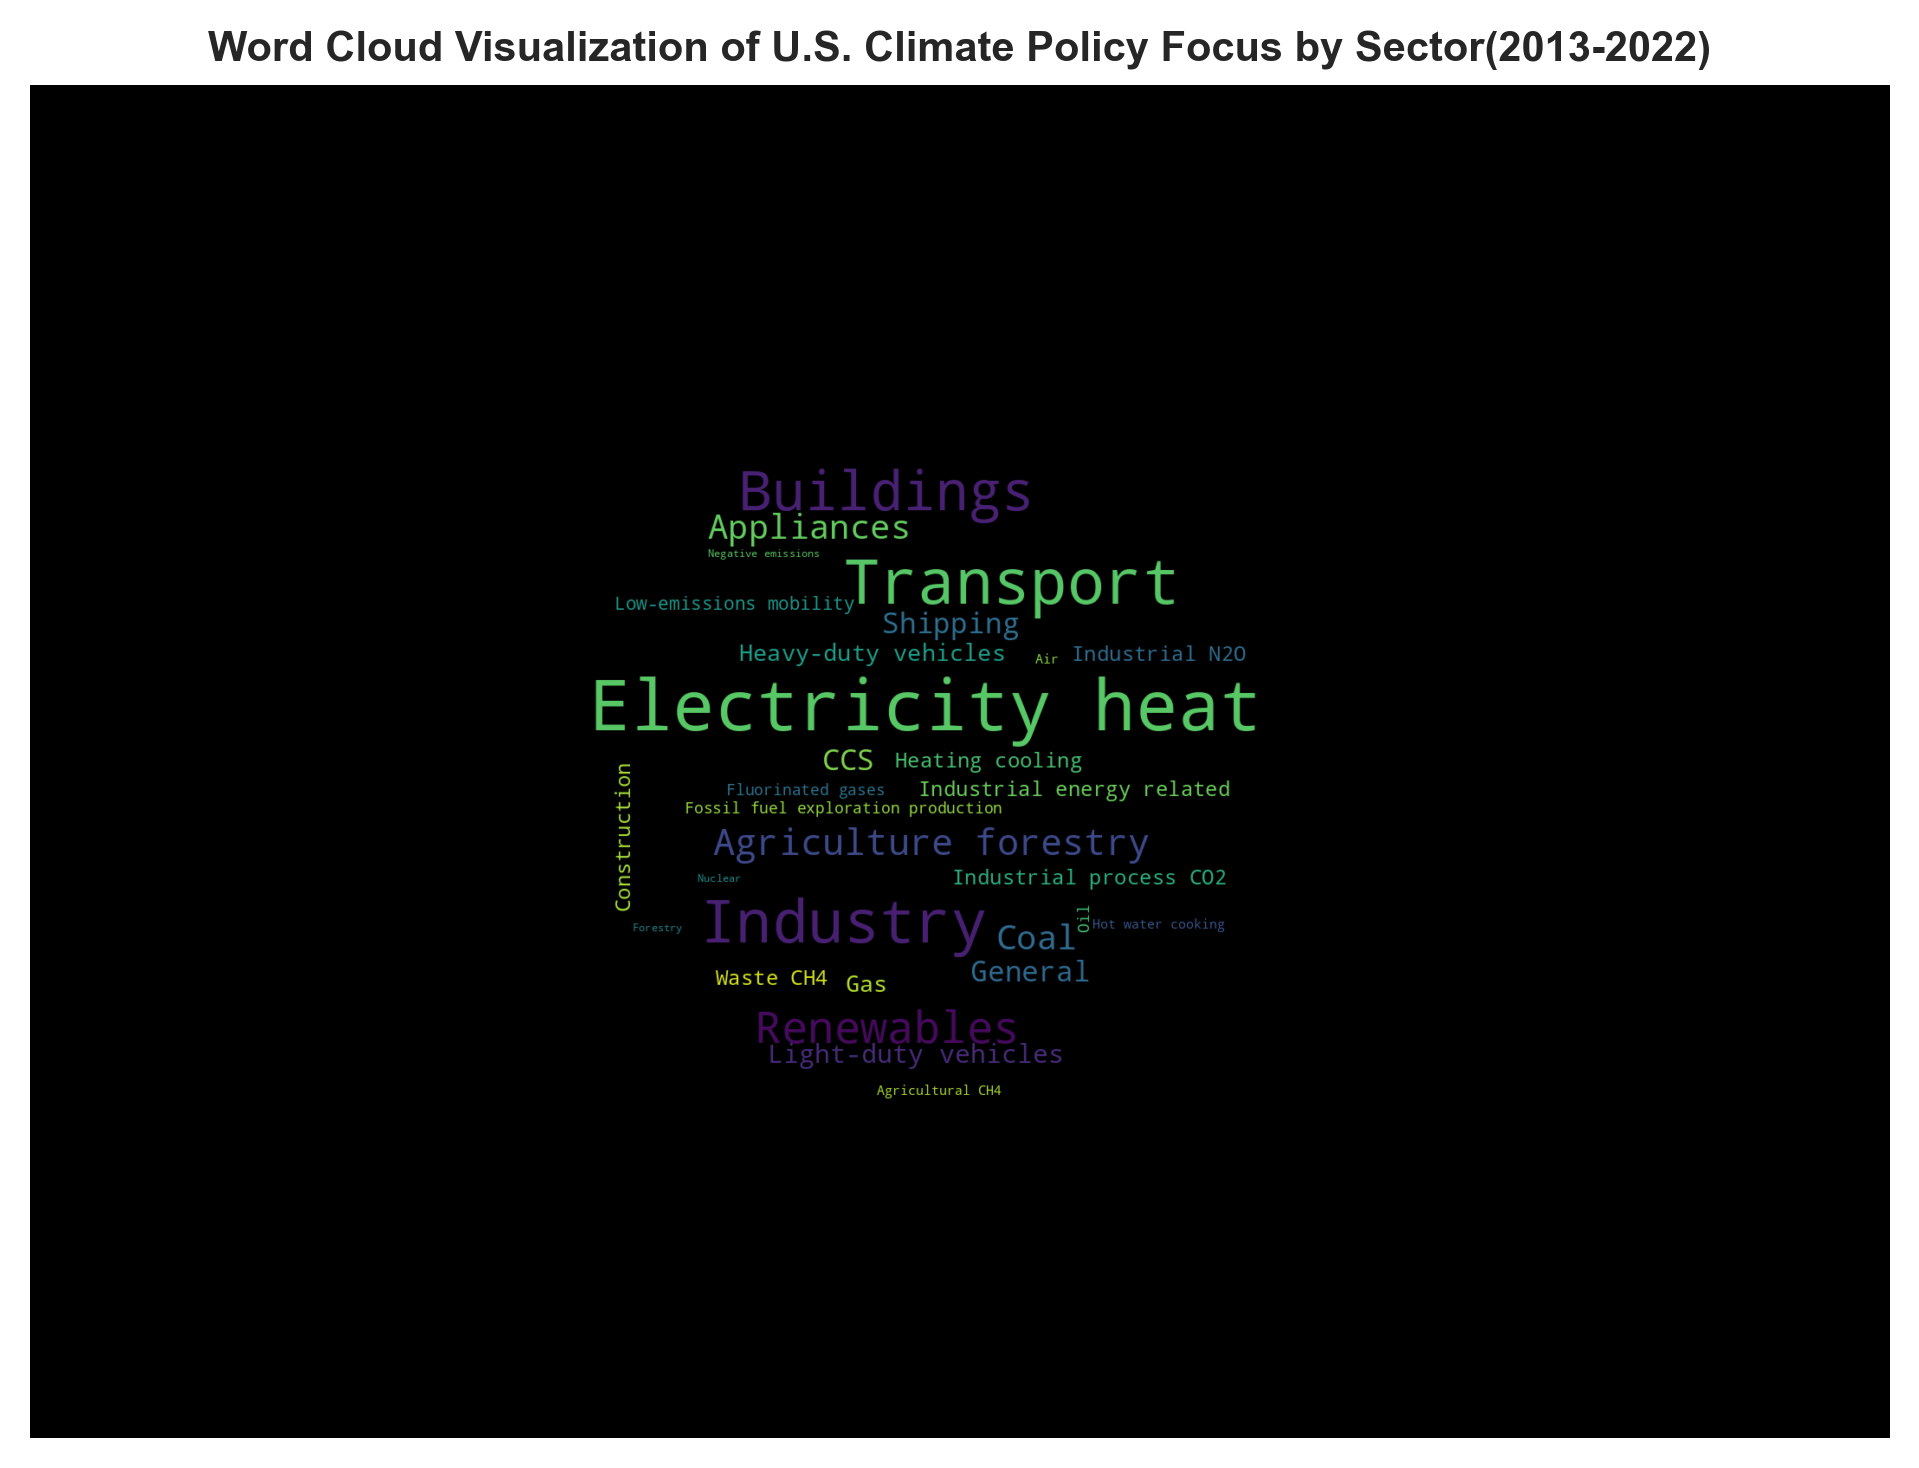

In [81]:
stopwords = {'and', 'the', 'of'}
# Usage 1:
us_policies_2013_2022 = us_policies[us_policies['decision_date'] >= 2013]

threshold = 1
image_path = '/Users/kyimoetun/Desktop/Projects/DSKUS_G1/Figures/earth_mask.png'
title = "Word Cloud Visualization of U.S. Climate Policy Focus by Sector(2013-2022)"
word_count = get_word_count(us_policies, 'sector')
generate_word_cloud(us_policies_2013_2022, image_path, title, word_count=word_count)

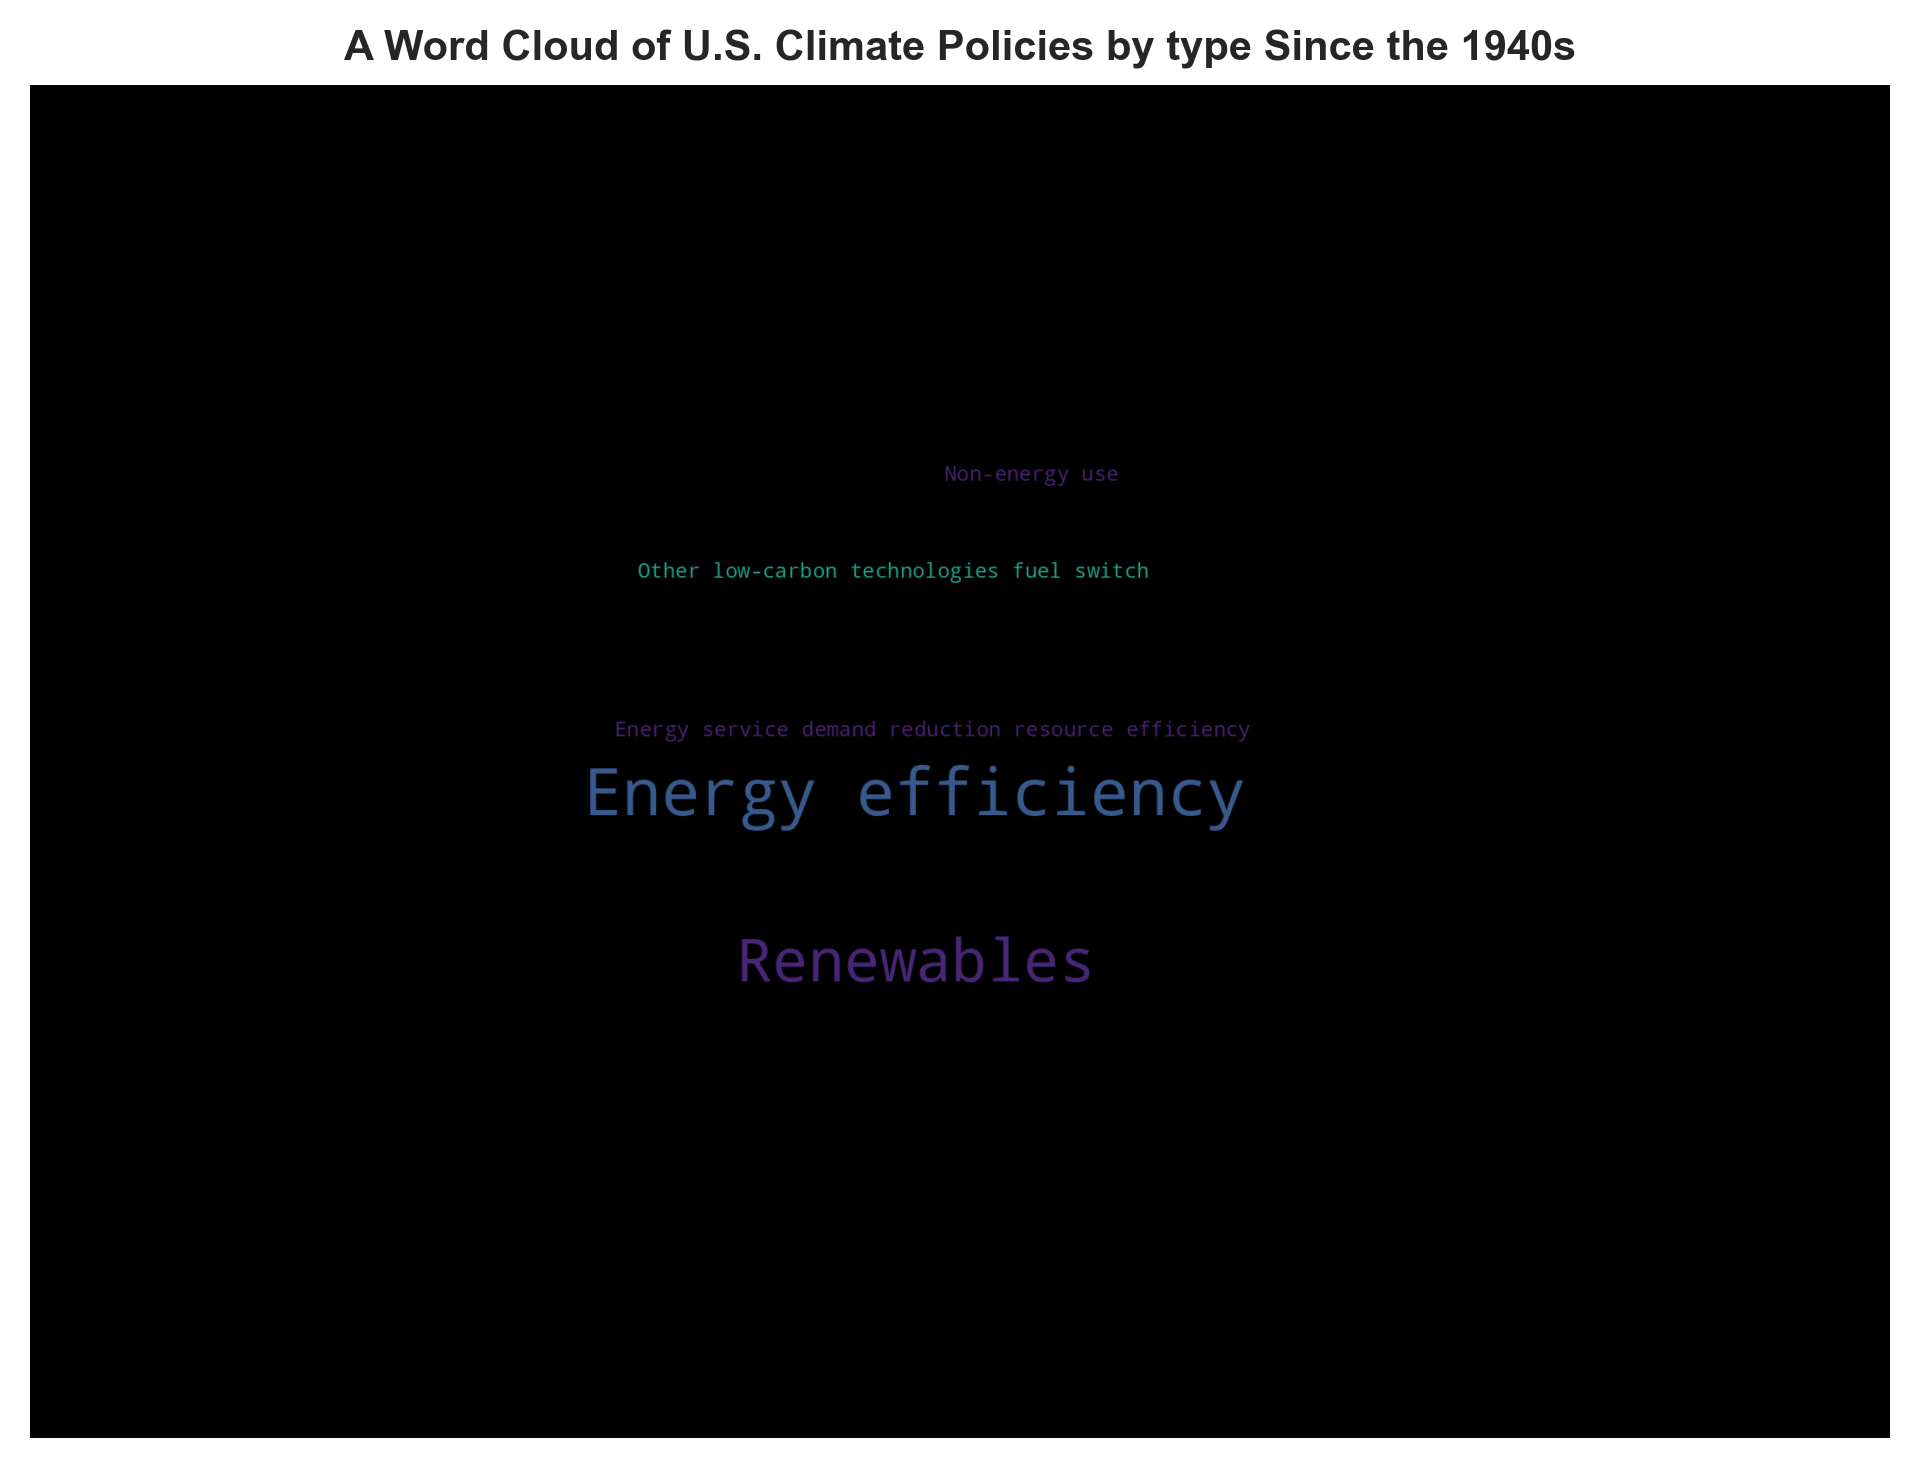

In [20]:
threshold = 2
title = "A Word Cloud of U.S. Climate Policies by type Since the 1940s"
word_count = get_word_count(us_policies, 'policy_type')
word_count2 = get_word_count(us_policies, 'policy_title')
generate_word_cloud(us_policies, image_path, title, word_count=word_count)

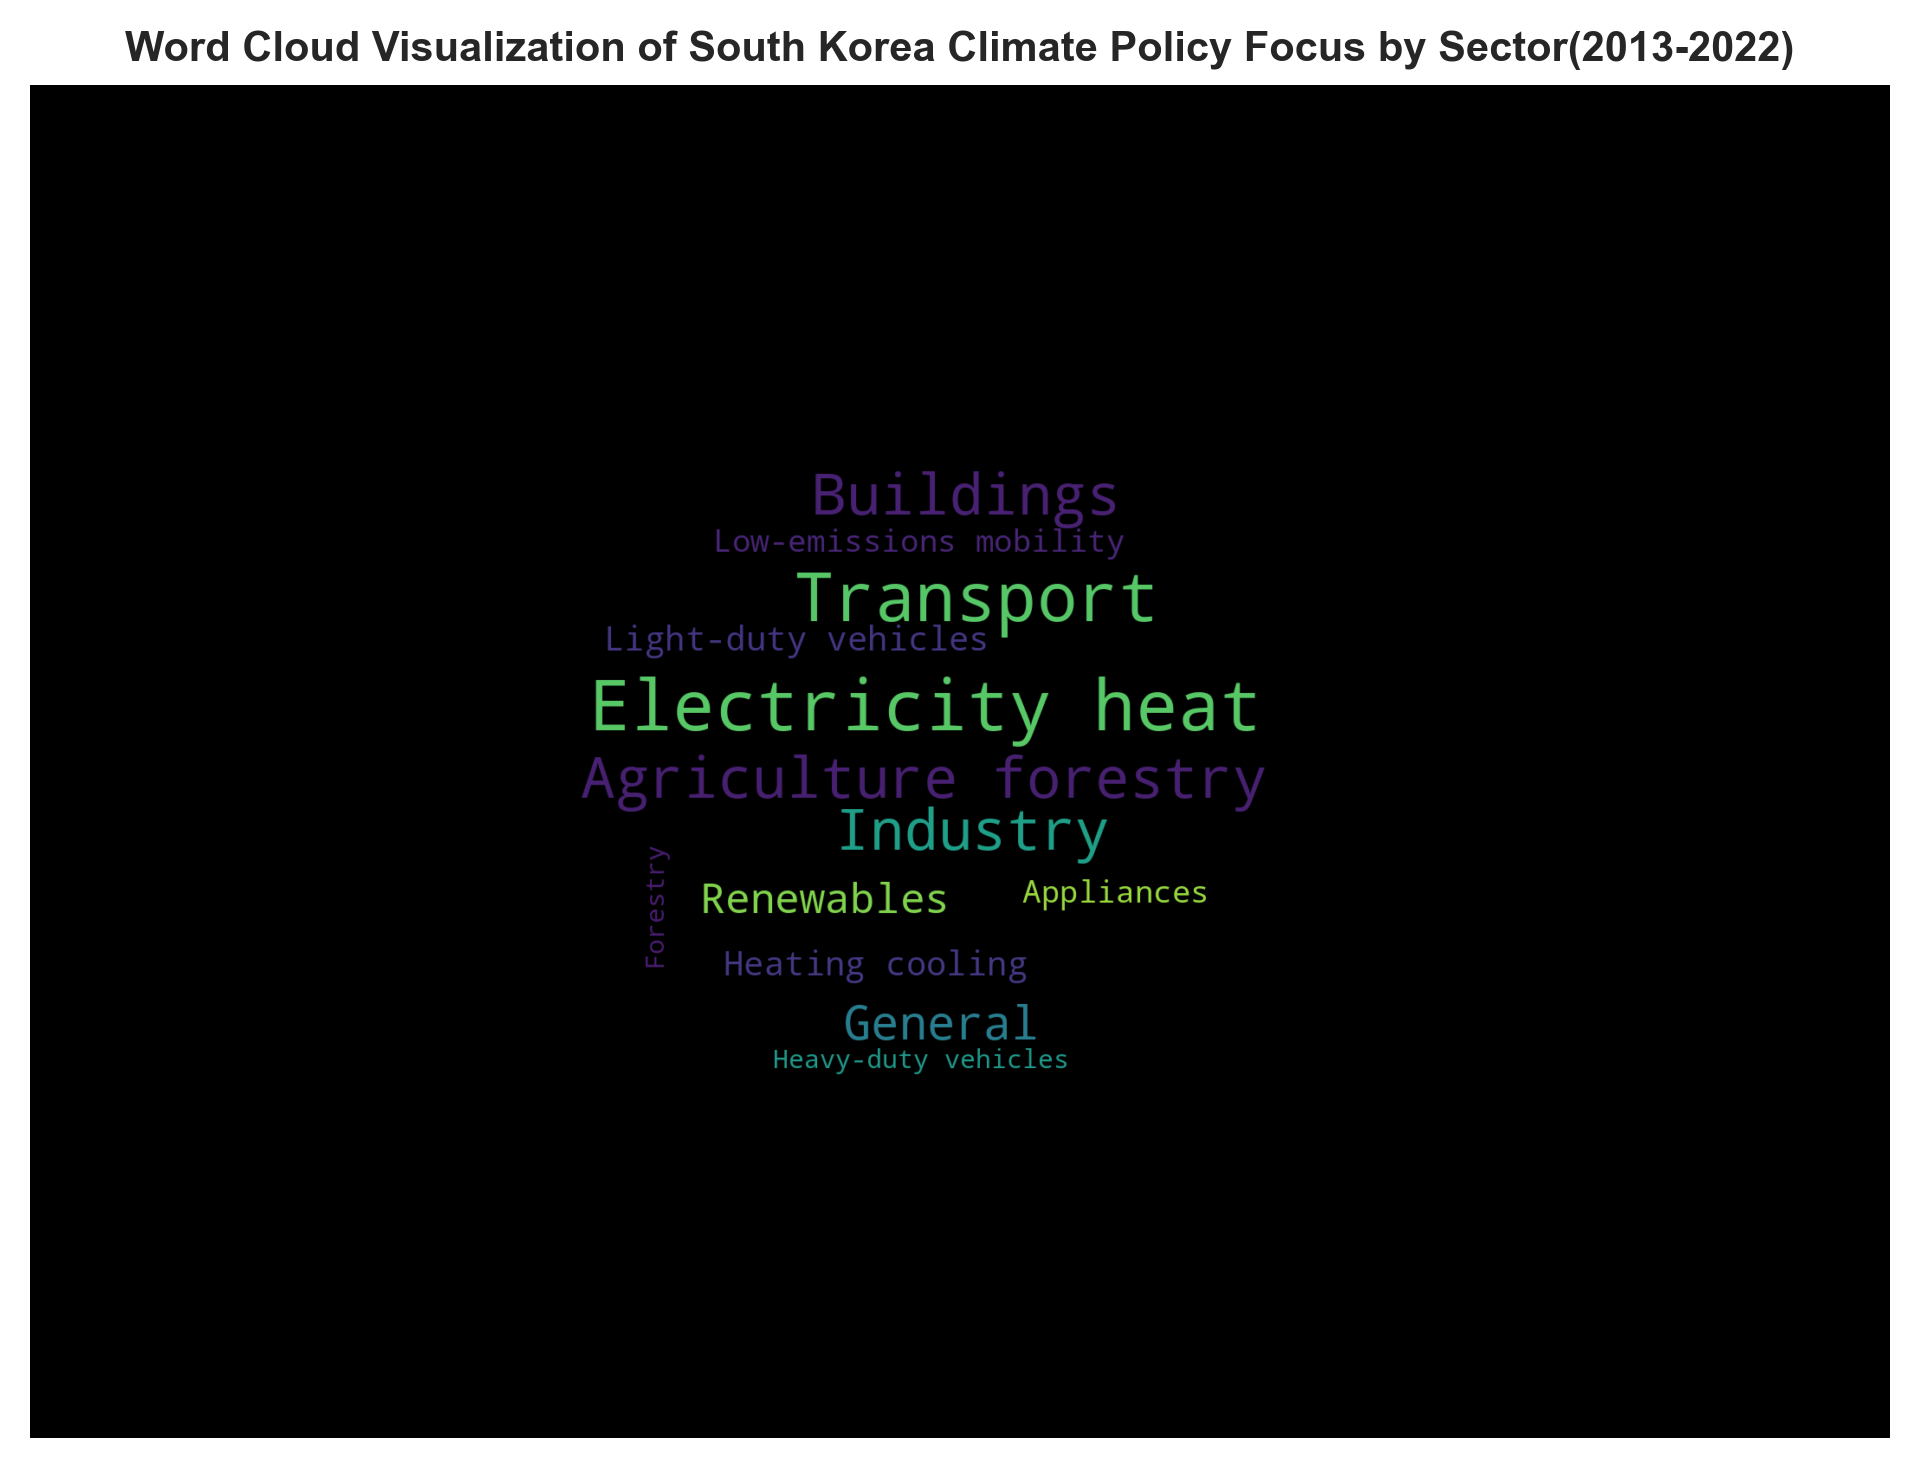

In [80]:
# Usage 1:
kor_policies_2013_2022 = kor_policies[kor_policies['decision_date'] >= 2013]

threshold = 1
image_path = '/Users/kyimoetun/Desktop/Projects/DSKUS_G1/Figures/earth_mask.png'
title = "Word Cloud Visualization of South Korea Climate Policy Focus by Sector(2013-2022)"
word_count = get_word_count(kor_policies_2013_2022, 'sector')
generate_word_cloud(kor_policies_2013_2022, image_path, title, word_count=word_count)

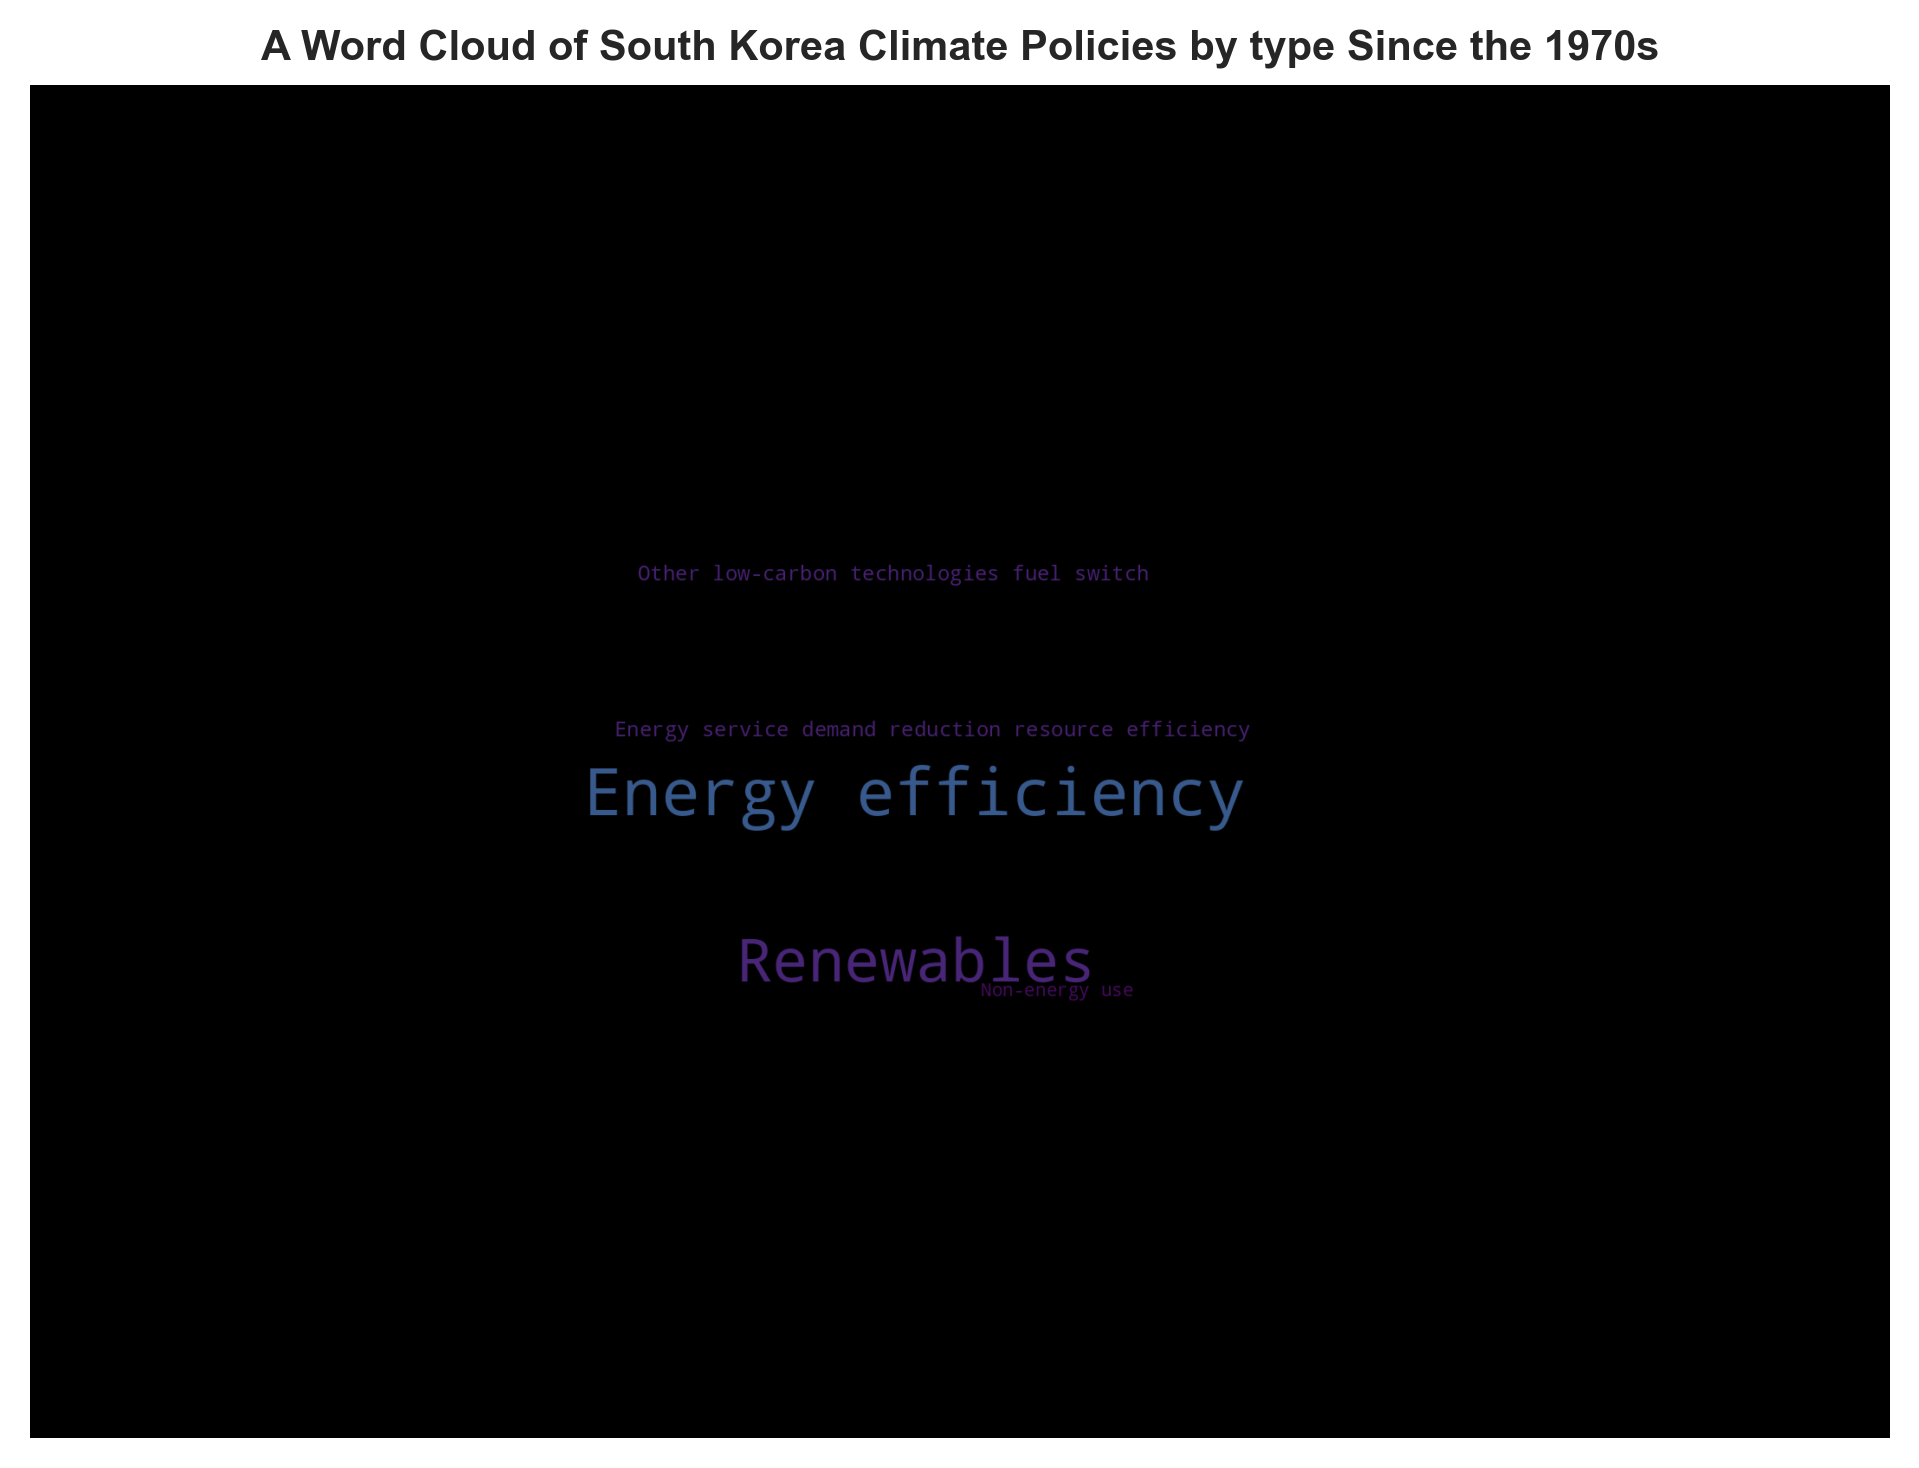

In [23]:
threshold = 2
title = "A Word Cloud of South Korea Climate Policies by type Since the 1970s"
word_count = get_word_count(kor_policies, 'policy_type')
generate_word_cloud(kor_policies, image_path, title, word_count=word_count)

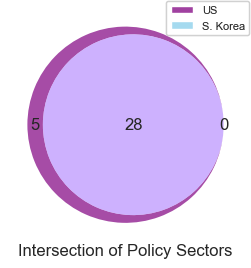

In [151]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

us_policies_sectors = list(get_word_count(us_policies, 'sector').keys())
kor_policies_sectors = list(get_word_count(kor_policies, 'sector').keys())

us_sectors_set = set(us_policies_sectors)
kor_sectors_set = set(kor_policies_sectors)

# Adjust figure size
plt.figure(figsize=(3, 3))
venn = venn2([us_sectors_set, kor_sectors_set], set_labels=(' ', ' '), set_colors=('purple', 'skyblue'), alpha = 0.7)

# Add a legend
us_patch = plt.Circle((0, -1), 0.1, fc=venn.get_patch_by_id('10').get_facecolor())
kor_patch = plt.Circle((0, -1), 0.1, fc=venn.get_patch_by_id('01').get_facecolor())
legend = plt.legend([us_patch, kor_patch], ['US', 'S. Korea'], loc='upper right', bbox_to_anchor=(1.06, 1.06), fontsize=8)

# Change the font size of the Venn diagram labels
for text in venn.set_labels:
    text.set_fontsize(12)

plt.gca().add_artist(legend)

# Add a title below the plot
plt.title("Intersection of Policy Sectors", y=-0.1)
plt.show()

In [72]:
us_minus_kor_sectors = us_sectors_set.difference(kor_sectors_set)
us_minus_kor_sectors

{'Agricultural CO2',
 'Fluorinated gases',
 'Industrial N2O',
 'Negative emissions',
 'Rail'}

#### Comparison of energy consumption for economic associations

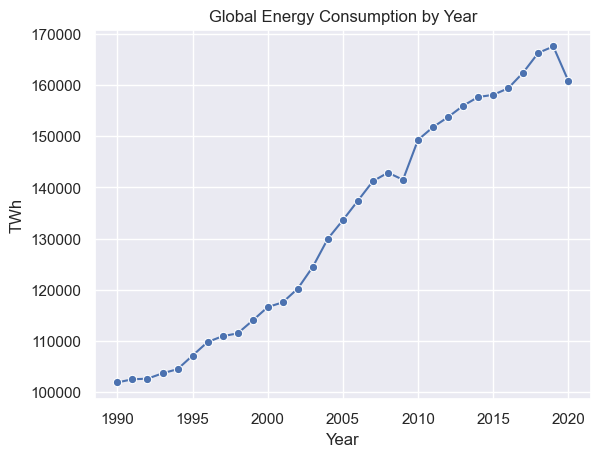

In [64]:
# Plot overall energy consumption by year
sns.set(style="darkgrid")
sns.lineplot(data=cont_consump, x='Year', y='World', marker='o')
plt.title("Global Energy Consumption by Year")
plt.xlabel("Year")
plt.ylabel("TWh")
plt.show()

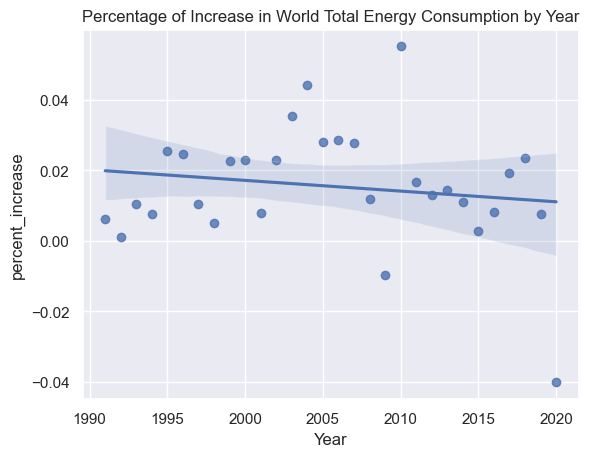

In [65]:
# Calculate the percentage increase or decrease in energy consumption compared to the previous year
world_df = cont_consump.loc[:,['Year', 'World']]
world_df['percent_increase'] = world_df['World'].pct_change()

# Plot the data
sns.regplot(x='Year', y='percent_increase', data=world_df)
plt.title('Percentage of Increase in World Total Energy Consumption by Year')
plt.show()

##### How has the energy consumption changed for Economic Aliances?

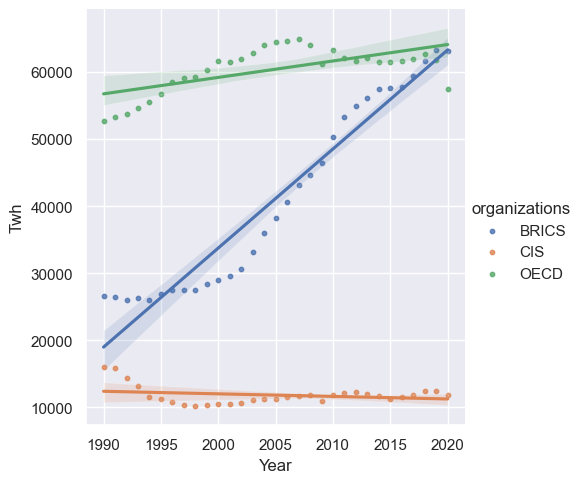

In [66]:
org_cols = ["BRICS", "CIS", "OECD"]
df = pd.melt(cont_consump, id_vars=["Year"], value_vars=org_cols, var_name="organizations", value_name="Twh")
df = df.dropna()

# Plot a regression line for each economic organization to identify trends in power consumption
# The trends of power consumption (TWh) of three economic organizations, BRICS, CIS, and OECD, are examined by year
sns.lmplot(data=df, x="Year", y="Twh", hue="organizations", scatter_kws={"s": 10})

##### Energy Consumption by countries over past 30 years

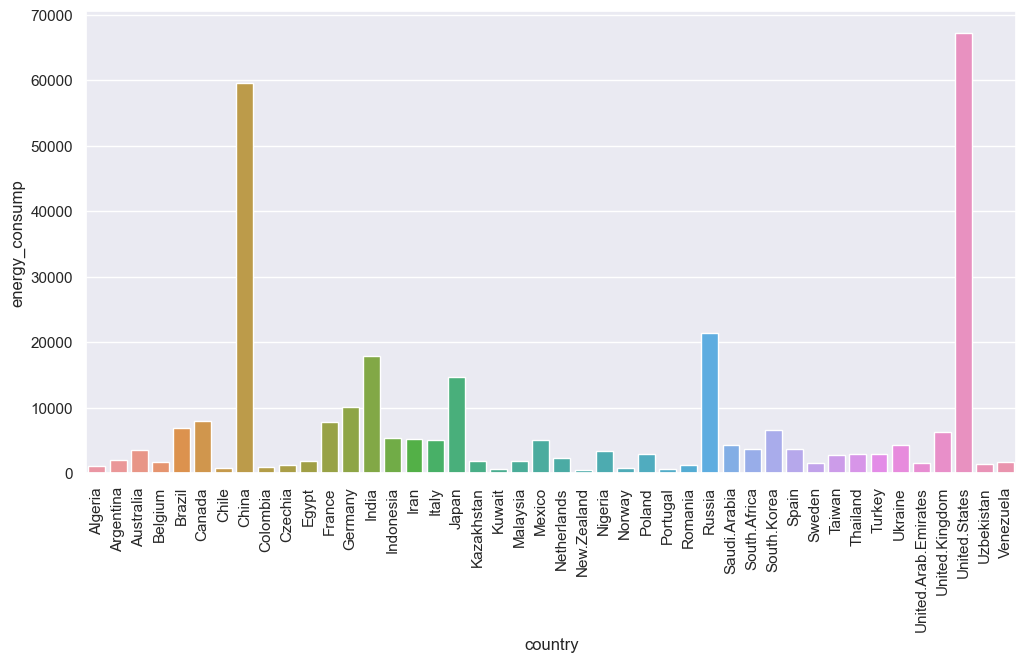

In [67]:
# Gather columns China to United Arab Emirates into a key-value pair
vars = country_consump.columns.tolist()
ctry_consump = pd.melt(country_consump, id_vars=['Year'], value_vars= vars[1:], var_name='country', value_name='energy_consump')
ctry_gup = ctry_consump.groupby('country')['energy_consump'].agg('sum').reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=ctry_gup, x='country', y='energy_consump')
plt.xticks(rotation=90)
plt.show()

##### 10 countries with the highest energy consumption

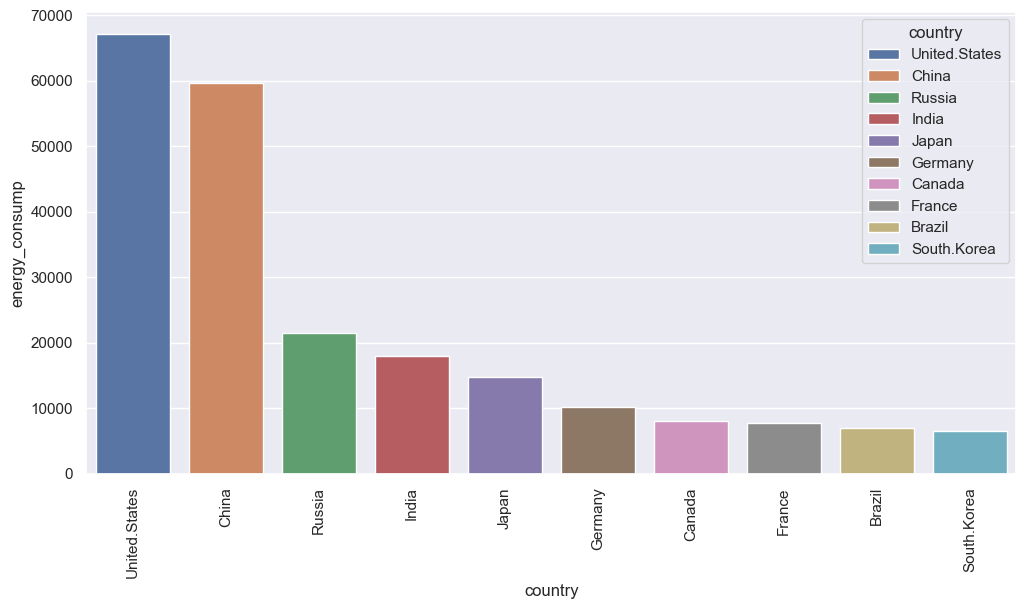

In [68]:
df = country_consump.melt(id_vars=['Year'], value_vars= vars[1:], var_name='country', value_name='energy_consump')

# Total energy consumption by country
df_sum = df.groupby('country').sum().reset_index()

# Top 10 Countries Extraction
top10 = df_sum.nlargest(10, 'energy_consump')

# Visualize as a bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='energy_consump', data=top10, hue = 'country', dodge = False)
plt.xticks(rotation=90)
plt.show()

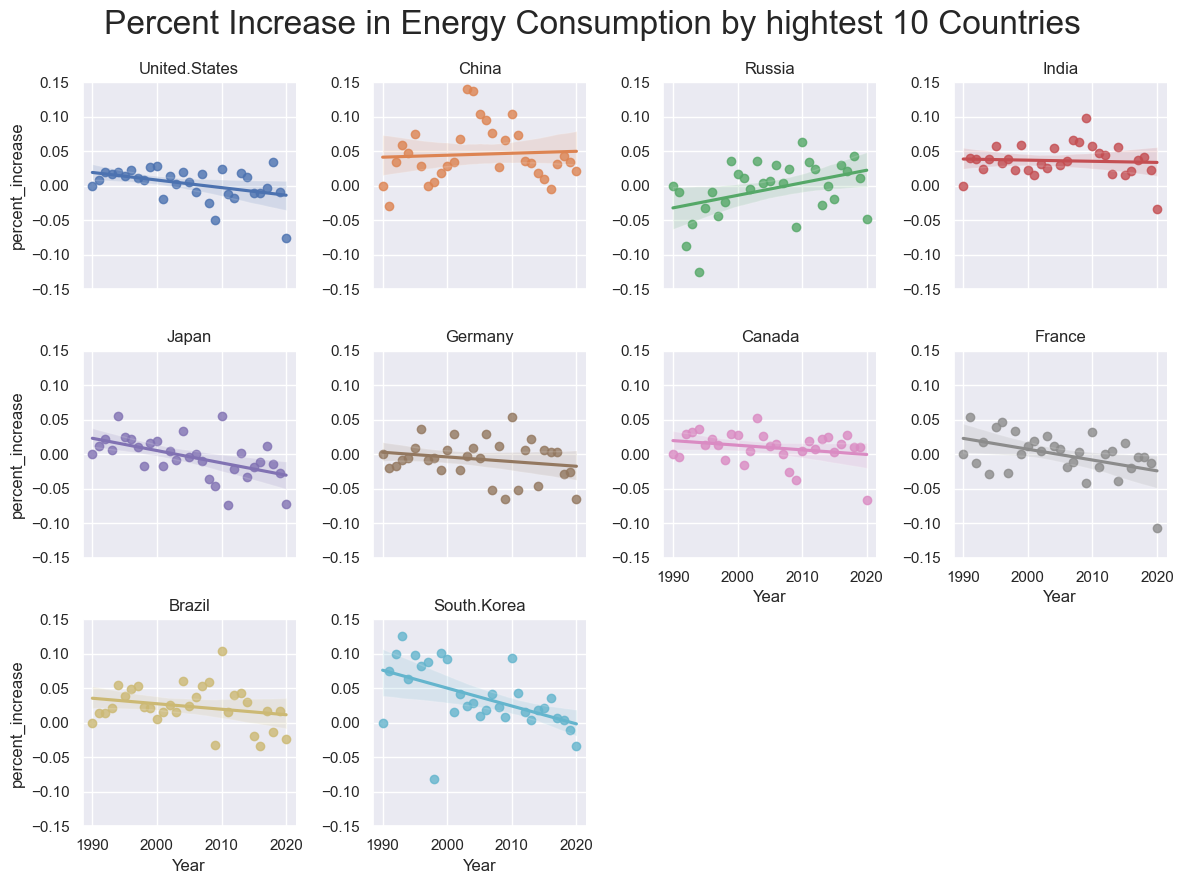

In [72]:
top10list = top10['country'].tolist()
# Calculate the percentage increase in total energy consumption per year in each of the 10 countries with the highest total energy consumption
melted_per = pd.melt(country_consump, id_vars=['Year'], value_vars=top10list, var_name='country', value_name='energy_consump')
melted_per['Percent Increase'] = (melted_per.groupby('country')['energy_consump'].apply(lambda x: x.pct_change()).replace([np.inf, -np.inf], np.nan)
.fillna(0))
melted_per = (melted_per.groupby('country').apply(lambda x: x.assign(percent_increase = (x['energy_consump'] - x['energy_consump'].shift(1, fill_value=x['energy_consump'].iloc[0]))/x['energy_consump'].shift(1, fill_value=x['energy_consump'].iloc[0]))).reset_index(drop=True))

# Plot the percentage increase in total energy consumption in the top 10 countries by year
g = sns.FacetGrid(data=melted_per, col='country', col_wrap=4, sharey=False, hue = 'country', ylim=(-0.15,0.15))
g.map_dataframe(sns.regplot, x='Year', y='percent_increase', marker='o')
g.set_titles(col_template='{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percent Increase in Energy Consumption by hightest 10 Countries', fontsize = 24)
plt.show()

&emsp; Except for Russia and China, it can be seen that the growth rate of energy consumption is decreasing.

#### Renewable sources vs Non-Renewable sources Energy Generation
##### Which energy source produces more energy?

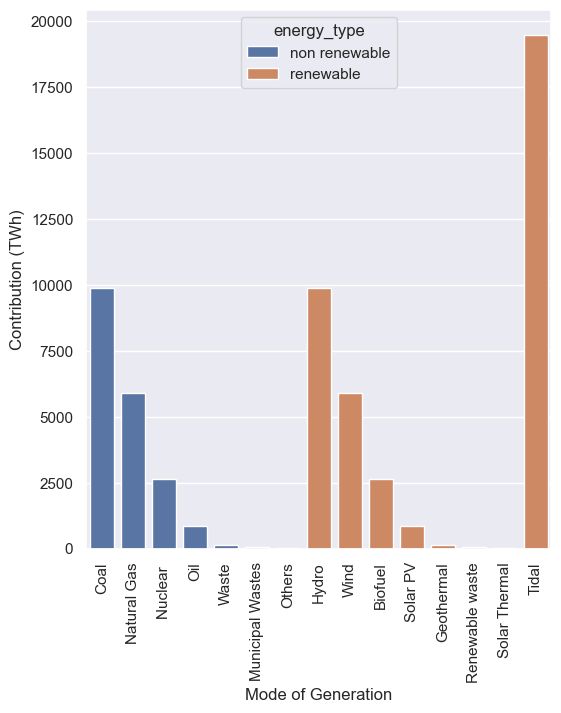

In [74]:
df = pd.concat([nonre_eng, re_eng_tot_gen])
df = df[df["Mode of Generation"] != "Total"]

# Plot by mode of generation
plt.figure(figsize=(6,7))
sns.barplot(x='Mode of Generation', y='Contribution (TWh)', hue='energy_type', data=df, dodge = False)
plt.xticks(rotation=90)
plt.show()

&emsp; Tidal energy is generated the most, followed by hydro energy. Coal is the non-renewable energy source that contributes the most to energy generation.

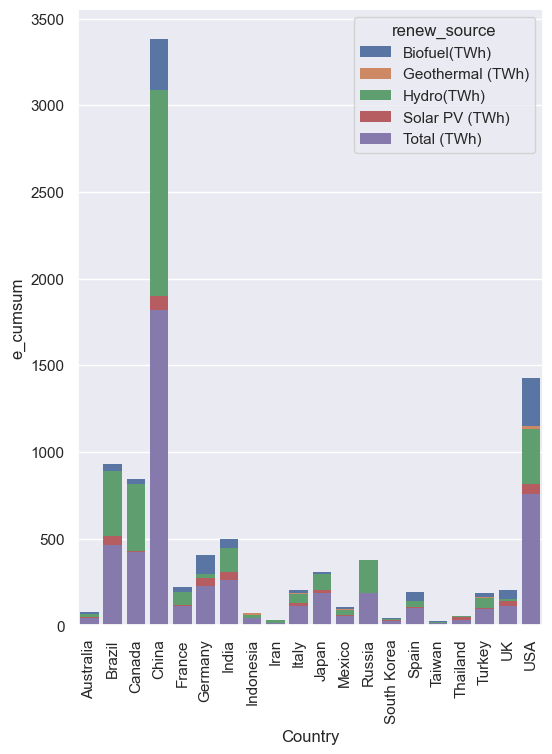

In [75]:
re_eng_countries_melt = pd.melt(re_eng_countries, id_vars='Country', var_name='renew_source', value_name='energy_Twh', 
                                value_vars=['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)', 'Total (TWh)'])

re_eng_countries_melt = pd.DataFrame(re_eng_countries_melt.groupby(['Country','renew_source']).energy_Twh.sum()).reset_index()
re_eng_countries_melt = re_eng_countries_melt.sort_values(by=['Country', 'renew_source'], ascending=False)
re_eng_countries_melt['e_cumsum'] = re_eng_countries_melt.groupby(['Country'])['energy_Twh'].cumsum()
re_eng_countries_melt = re_eng_countries_melt.sort_values(by=['Country', 'renew_source'], ascending=True)

plt.figure(figsize=(6,8))
sns.barplot(data=re_eng_countries_melt, x='Country', y='e_cumsum', hue='renew_source', dodge=False, edgecolor='None')
plt.xticks(rotation=90)
plt.show()

&emsp; China has the highest amount of renewable energy use, followed by the United States, Brazil, and Canada.

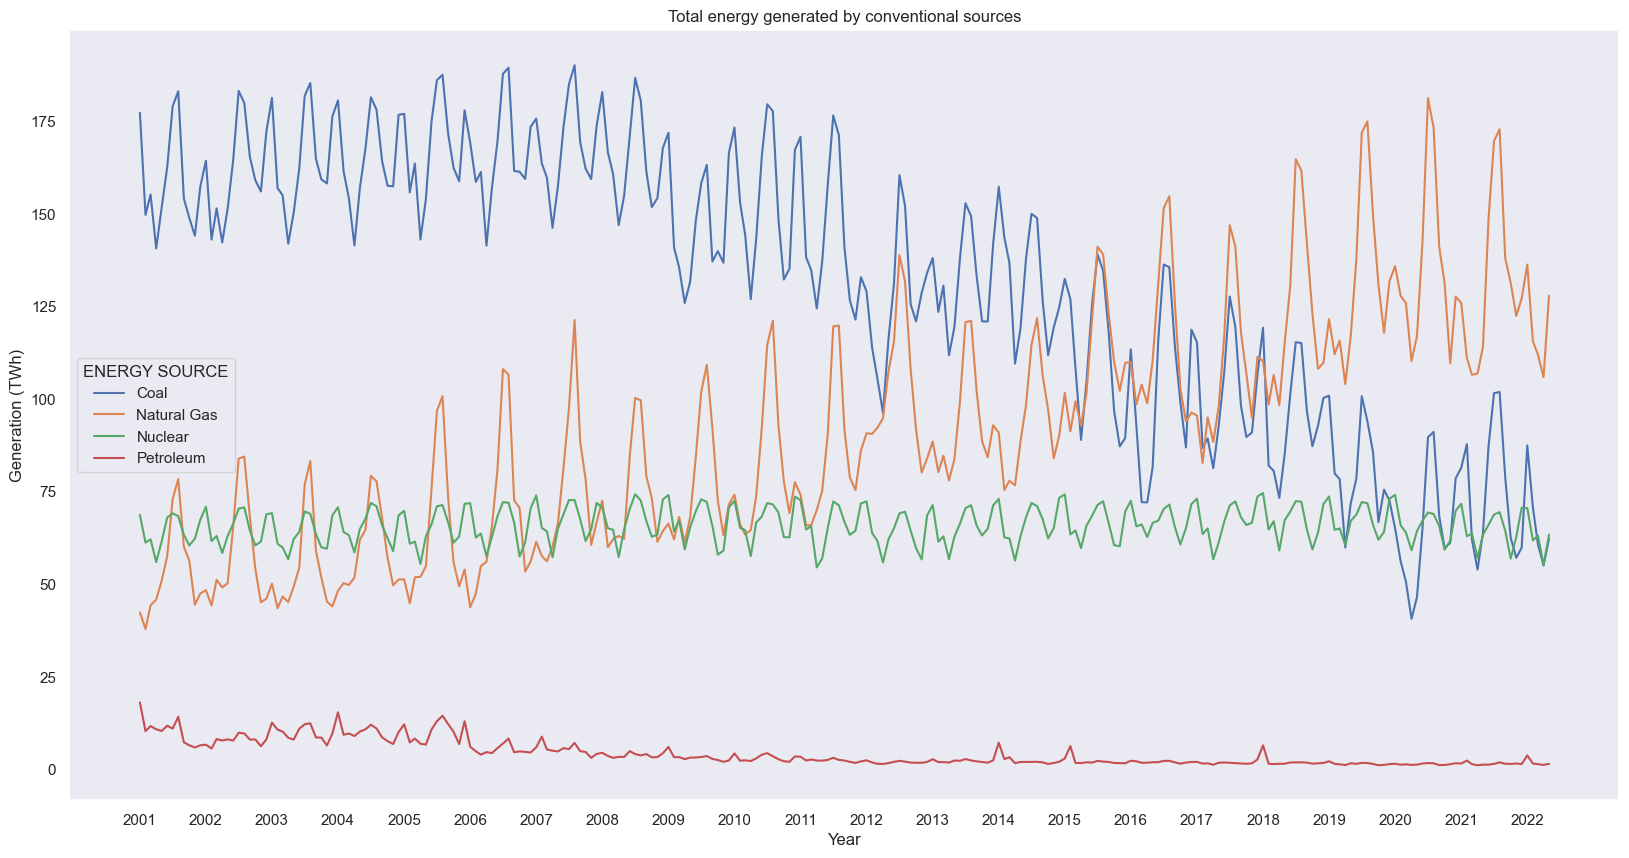

In [76]:
conventional=["Coal","Natural Gas","Nuclear","Petroleum"]
#Figsize
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=plot2[plot2["ENERGY SOURCE"].isin(conventional)],
                x="Date",y="Generation (TWh)",hue="ENERGY SOURCE").xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#Plot additional properties
plt.grid()
plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by conventional sources")
plt.xlabel("Year");

&emsp; This visualization presents a straightforward line graph or time series plot, displaying the relationship between energy generation in terawatt-hours (TWh) and the corresponding years. The different lines in the graph represent the trends of various energy sources over time.

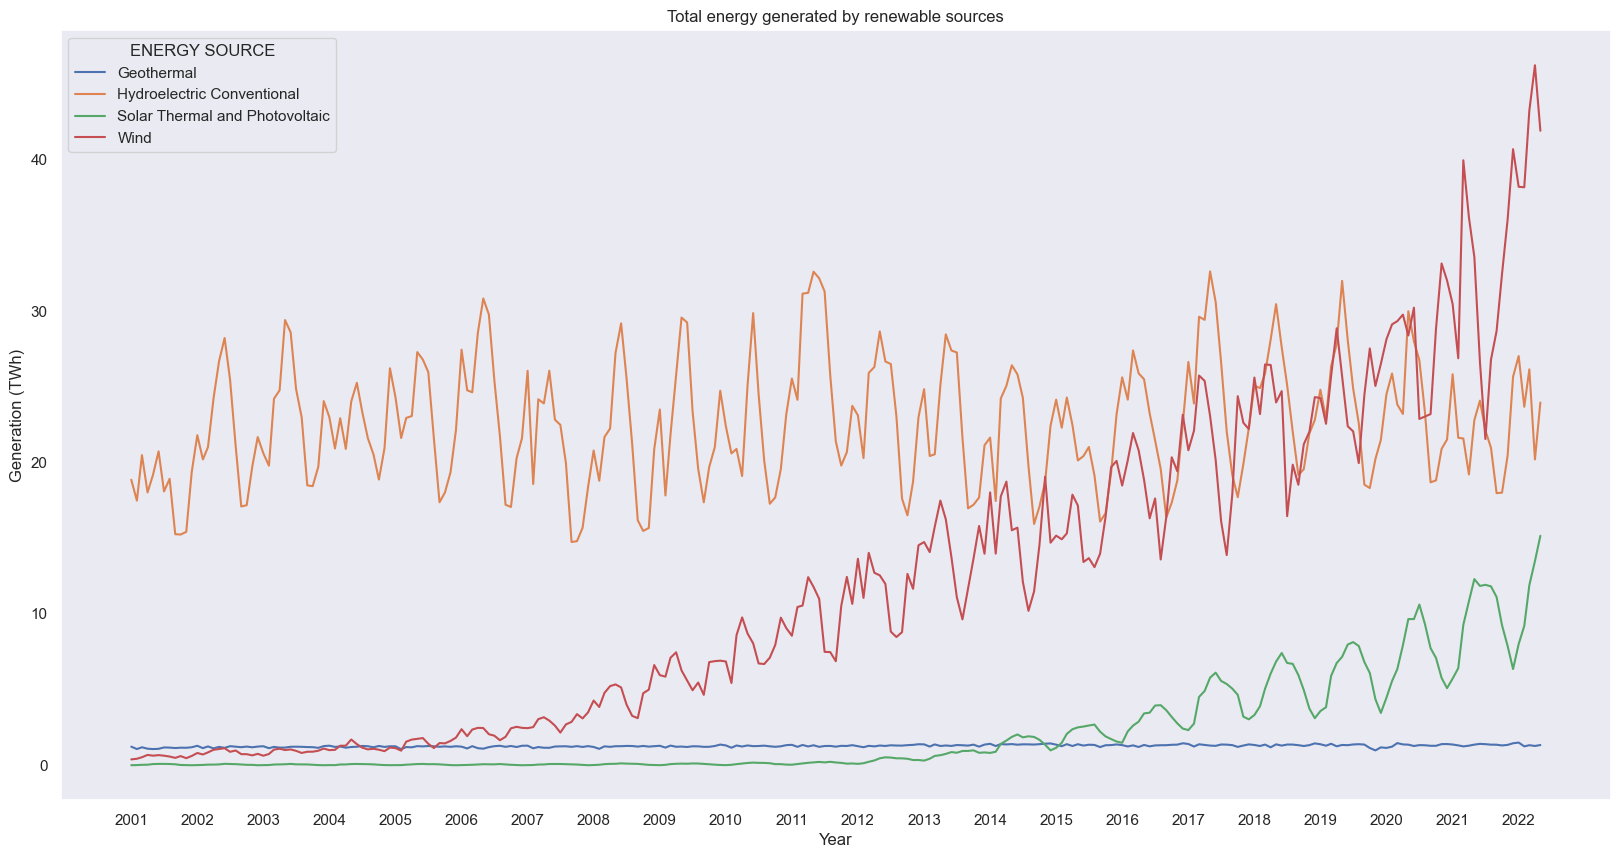

In [77]:
renewable=["Hydroelectric Conventional","Solar Thermal and Photovoltaic", "Wind","Geothermal"]
#Figsize
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=plot2[plot2["ENERGY SOURCE"].isin(renewable)],
                x="Date",y="Generation (TWh)",hue="ENERGY SOURCE").xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#Plot additional properties
plt.grid()
plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by renewable sources")
plt.xlabel("Year");

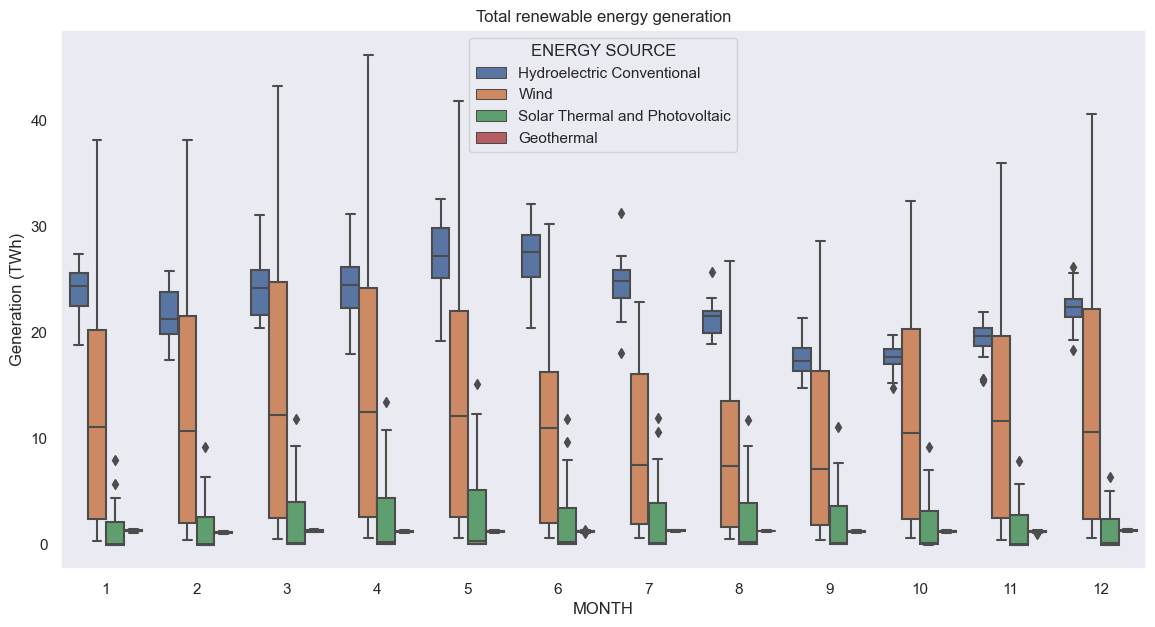

In [78]:

#Data filtering
total_dist=ren_gen[(ren_gen["STATE"]=="US-TOTAL") & (ren_gen["ENERGY SOURCE"].isin(renewable)) &
                (ren_gen["TYPE OF PRODUCER"]=="Total Electric Power Industry")]
#Creating a column with the month data
total_dist["MONTH"]=total_dist.index.month
#Energy convertion
total_dist["Generation (TWh)"]= total_dist["GENERATION (Megawatthours)"]/1000000
#Plotting
plt.figure(figsize=(14,7))
plt.grid()
#Boxplot
sns.boxplot(data=total_dist,x="MONTH",y="Generation (TWh)",hue="ENERGY SOURCE")
plt.title("Total renewable energy generation");

&emsp; This visual depicts the monthly generation of energy in TWh using non-traditional sources, plotted against the corresponding time stamps.

In [79]:
fig = px.choropleth(
    co2_df,
    locations="country_code",
    color="2010",
    hover_name="Country Name",
    hover_data=["2010"],
    title="CO2 Emission(metric tons per capita) Around the world in 2010",
    color_continuous_scale=px.colors.sequential.Blues,
    
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

&emsp; This plot is a geographic interactive chloropleth that allows us to easily view the per capita CO2 emissions in metric tonnes for the year 2010. The use of color helps to interpret the emission intensity in different regions of the world.

In [80]:
fig = px.choropleth(
    co2_df,
    locations="country_code",
    color="2019",
    hover_name="Country Name",
    hover_data=["2019"],
    title="CO2 Emission(metric tons per capita) Around the world in 2019",
    color_continuous_scale=px.colors.sequential.Oranges,
    
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

&emsp; The interactive geospatial choropleth plot shown below provides a visual representation of the per capita CO2 emissions in metric tonnes for the year 2019. By utilizing this plot, it becomes possible to quickly compare the CO2 emissions and their fluctuation from 2010 to 2019.

Text(167.25, 0.5, 'Regions')

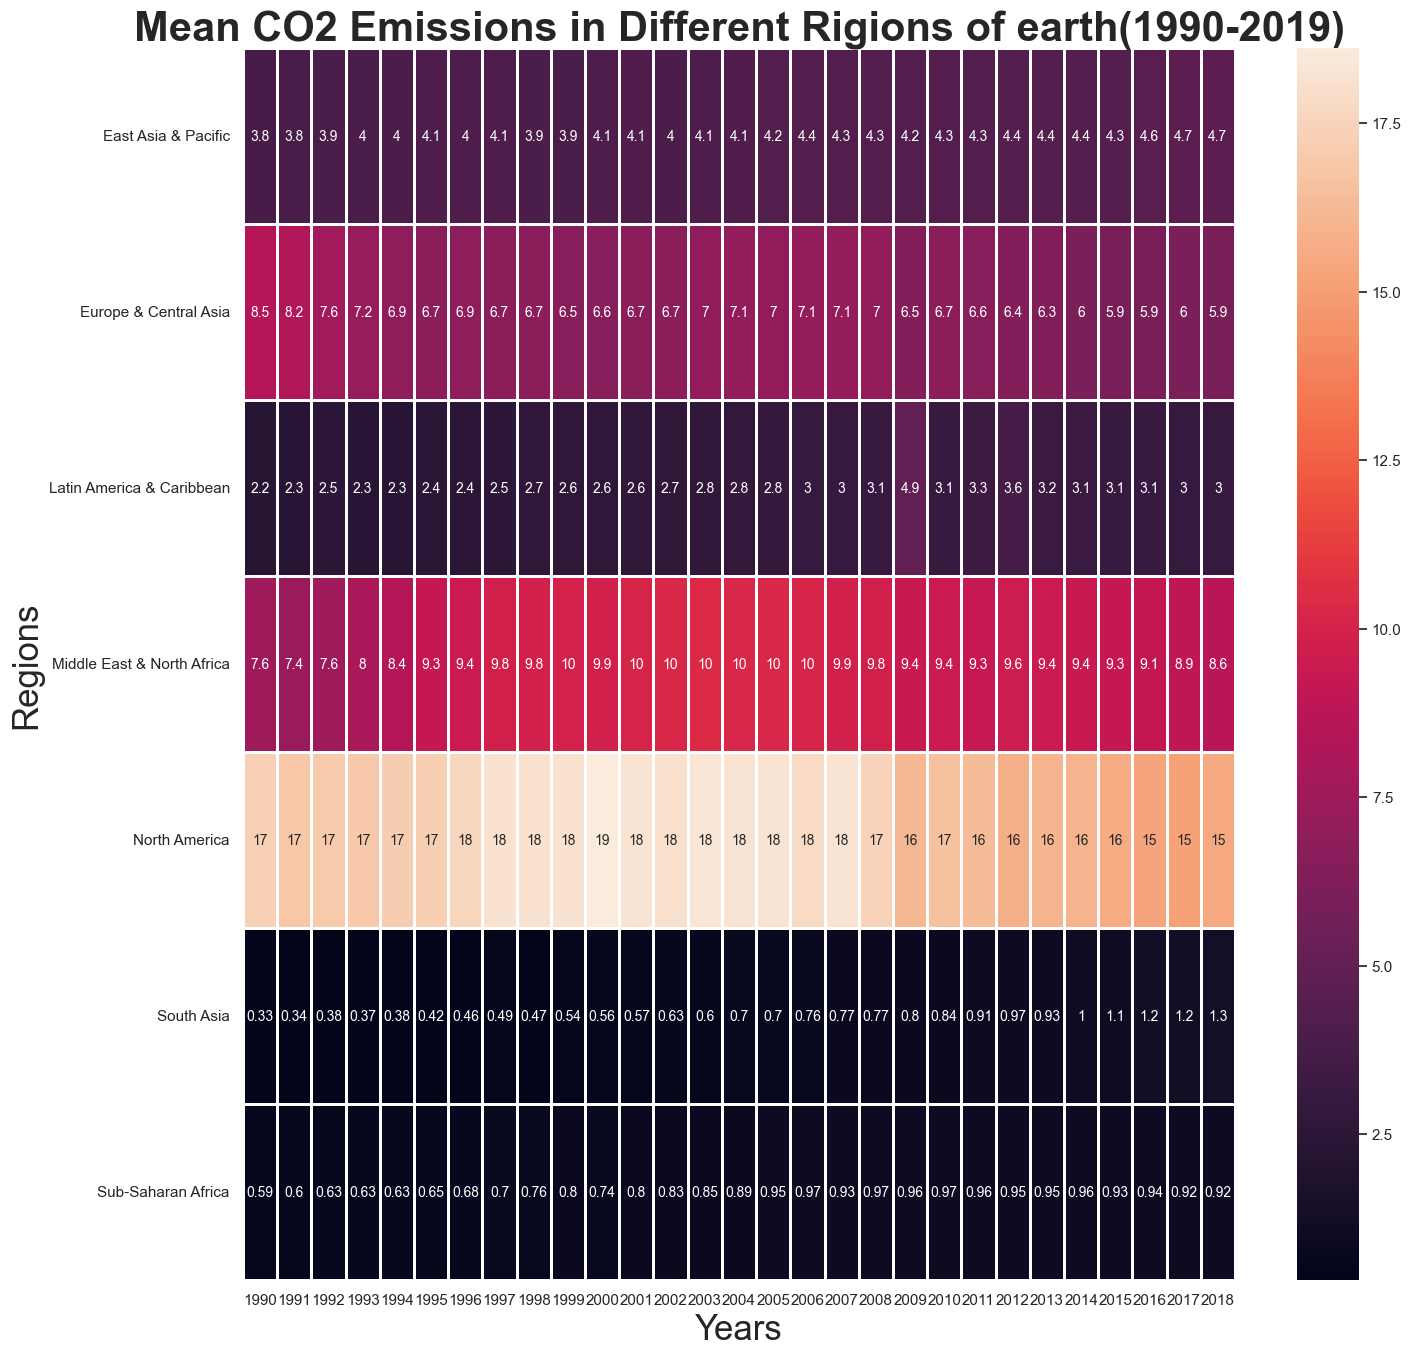

In [81]:
columns=np.arange(1990,2019).tolist()
columns_str = map(str,columns)
list_of_year = list(columns_str)

co2_region_df = co2_df.groupby('Region')[list_of_year].mean()
co2_region_df.unstack()

plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = 10
plt.title("Mean CO2 Emissions in Different Rigions of earth(1990-2019)",fontweight="bold",fontdict={'fontsize': 30})
sns.heatmap(co2_region_df,linecolor='white',linewidths=1,annot=True)
plt.xlabel('Years',fontdict={'fontsize': 25})
plt.ylabel('Regions',fontdict={'fontsize': 25})